### Introduction
* 모델 해석 가능성에 대한 Captum의 접근 방식은 귀인 측면에서 이루어짐.
* Captum에는 세 가지 종류의 속성이 있음.
  + **특성 기여**는 특정 출력을 생성한 입력의 특성 측면에서 특정 출력을 설명하려고 함. (e.g : 영화 리뷰가 리뷰의 특정 단어에 관해 긍정적인지 부정적인지 설명하는 것이 특징 귀속의 예)
  + **레이어 속성**은 특정 입력 이후 모델의 숨겨진 레이어 활동을 검사함. (레이어 속성의 예에서 입력 이미지에 대한 응답으로 컨볼루션 레이어의 공간적으로 매핑된 출력을 조사함.)
  + **뉴런 속성**은 레이어 속성과 유사하지만 단일 뉴런의 활동에 중점을 둠.

* 이 대화형 Notebook에서는 기능 속성과 레이어 속성을 살펴봄.
* 세 가지 속성 유형 각각에는 이와 관련된 여러 **속성 알고리즘**이 있음.
* 많은 기여 분석 알고리즘은 크게 두 가지 범주로 나뉨.
  + **기울기 기반 알고리즘**은 입력에 대한 모델 출력, 레이어 출력 또는 뉴런 활성화의 역방향 기울기를 계산함.
  + **통합 그래디언트(기능용)**, **레이어 그래디언트 활성화** 및 **뉴런 컨덕턴스**는 모두 그래디언트 기반 알고리즘임.
  + **섭동 기반 알고리즘**은 입력 변화에 대한 응답으로 모델, 레이어 또는 뉴런의 출력 변화를 검사함.
  + 입력 섭동은 방향이 지정되거나 무작위일 수 있음.
  + **Occlusion, Feature Ablation** 및 **Feature Permutation**은 모두 섭동 기반 알고리즘임.

* 아래에서 두 가지 유형의 알고리즘을 모두 살펴보겠음.
* 특히 대규모 모델이 관련된 경우에는 검사 중인 입력 기능과 쉽게 연관되는 방식으로 속성 데이터를 시각화하는 것이 중요할 수 있음.
* Matplotlib, Plotly 또는 유사한 도구를 사용하여 자신만의 시각화를 만드는 것이 확실히 가능하지만 Captum은 속성과 관련된 향상된 도구를 제공함.
  + catum.attr.visualization 모듈(아래에서 viz로 가져옴)은 이미지와 관련된 속성을 시각화하는 데 유용한 기능을 제공함.
  + **Captum Insights**는 이미지, 텍스트 및 임의 모델 유형에 대해 미리 만들어진 시각화 기능을 갖춘 시각화 위젯을 제공하는 Captum 기반의 사용하기 쉬운 API 임.
* 이 두 시각화 도구 세트는 모두 이 Notebook에서 시연됨.
* 처음 몇 가지 예는 컴퓨터 비전 사용 사례에 중점을 두지만 마지막에 있는 Captum Insights 섹션에서는 다중 모델, 시각적 질문 및 답변 모델의 속성 시각화를 보여줌.

### Installation
* 시작하기 앞서, 다음 Python 환경이 필요함.
  + Python version 3.6 or higher
  + For the Captum Insights example, Flask 1.1 or higher
  + PyTorch version 1.2 or higher (the latest version is recommended)
  + TorchVision version 0.6 or higher (the latest version is recommended)
  + Captum (the latest version is recommended)

* Anaconda 또는 pip 가상 환경에 Captum을 설치하려면 아래 환경에 적합한 명령을 사용함.

* With conda:

In [9]:
# conda install pytorch torchvision captum -c pytorch

* With pip:

In [10]:
# pip install torch torchvision captum

* 설정한 환경에서 이 노트북을 다시 시작하면 바로 사용할 수 있음.

### A First Example
* 시작하려면 간단하고 시각적인 예를 들어봄.
* ImageNet 데이터 세트에 사전 훈련된 ResNet 모델부터 시작하겠음.
* 테스트 입력을 받고 다양한 **특징 속성 알고리즘**을 사용하여 입력 이미지가 출력에 어떤 영향을 미치는지 조사하고 일부 테스트 이미지에 대한 이 입력 속성 맵의 유용한 시각화를 확인함.

* 먼저 일부는 다음과 같음.

In [11]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

* 이제 TorchVision 모델 라이브러리를 사용하여 사전 훈련된 ResNet을 다운로드하겠음.

* 훈련중이 아니기 때문에 지금은 평가 모드로 전환하겠음.

In [12]:
model = models.resnet101(weights='IMAGENET1K_V1')
model = model.eval()

* 이 대화형 Notebook이 있는 곳에는 cat.jpg 파일이 포함된 img 폴더도 있어야 함.

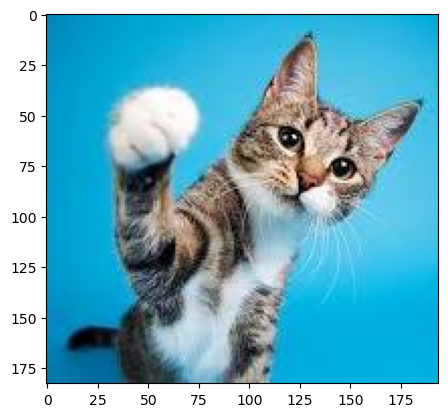

In [13]:
test_img = Image.open('img/cat.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()

* 우리의 ResNet 모델은 ImageNet 데이터 세트에서 훈련되었으며 이미지가 특정 크기일 것으로 예상하고 채널 데이터는 특정 값 범위로 정규화되었음.
* 또한 모델이 인식하는 카테고리에 대해 사람이 읽을 수 있는 레이블 목록을 가져올 것.
* 이 레이블도 img 폴더에 있어야 함.

In [14]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

labels_path = 'img/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

* 이제 우리는 질문을 할 수 있음.
* 우리 모델은 이 이미지가 무엇을 나타낸다고 생각하는지?

In [15]:
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: tabby ( 0.5821260213851929 )


* 우리는 ResNet이 우리의 고양이 이미지를 실제로 고양이로 생각한다는 것을 확인함.
* 그런데 왜 모델은 이것이 고양이의 이미지라고 생각하는건지?
* 이에 대한 해답을 찾기 위해 Captum을 살펴봄.

### Feature Attribution with Integrated Gradients
* **Feature attribution**은 특정 출력을 입력 특성에 귀속시킴.
* 특정 입력(여기서는 테스트 이미지)을 사용하여 특정 출력 기능에 대한 각 입력 기능의 상대적 중요성에 대한 맵을 생성함.
* 통합 그래디언트(Integrated Gradients)는 Captum에서 사용할 수 있는 특징 속성 알고리즘 중 하나.
* 통합 그래디언트는 입력에 대한 모델 출력의 그래디언트 적분을 근사화하여 각 입력 기능에 중요도 점수를 할당함.
* 우리의 경우 출력 벡터의 특정 요소(즉, 선택한 카테고리에 대한 모델의 신뢰도를 나타내는 요소)를 취하고 통합 그래디안트을 사용하여 입력 이미지의 어떤 부분이 이 출력에 기여했는지 이해함.
* Integrated Gradients의 중요도 맵이 있으면 Captum의 시각화 도구를 사용하여 중요도 맵에 대한 유용한 표현을 제공함.
* Captum의 visible_image_attr() 함수는 속성 데이터 표시를 사용자 정의하기 위한 다양한 옵션을 제공함.
* 여기서는 사용자 정의 Matplotlib 색상 맵을 전달함.
* Integrated_gradients. attribute() 호출로 셀을 실행하는 데는 일반적으로 1~2분이 소요됨.

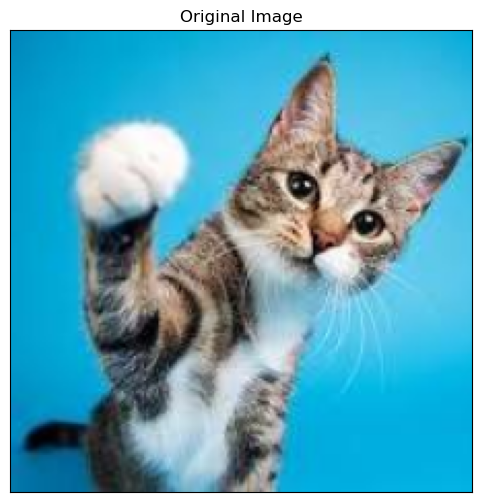

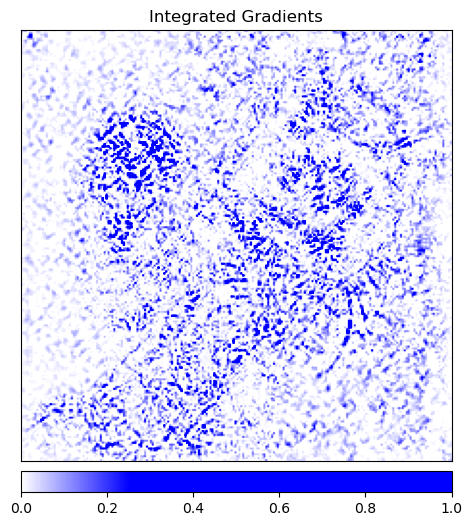

In [16]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(input_img, target=pred_label_idx, n_steps=200)

# Show the original image for comparison
_ = viz.visualize_image_attr(None, np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                      method="original_image", title="Original Image")

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

* 위 이미지에서는 통합 그래디언트가 이미지 내 고양이 위치 주변에 가장 강한 신호를 제공하는 것을 볼 수 있음.

### Feature Attribution with Occlusion
* 기울기 기반 기여 분석 방법은 입력에 대한 출력 변화를 직접 계산한다는 측면에서 모델을 이해하는 데 도움이 됨.
* 섭동 기반 기여 분석 방법은 입력에 대한 변경 사항을 도입하여 출력에 미치는 영향을 측정함으로써 이에 더 직접적으로 접근함.
* 폐색은 그러한 방법 중 하나임.
* 여기에는 입력 이미지의 섹션을 교체하고 출력 신호에 미치는 영향을 검사하는 작업이 포함됨.


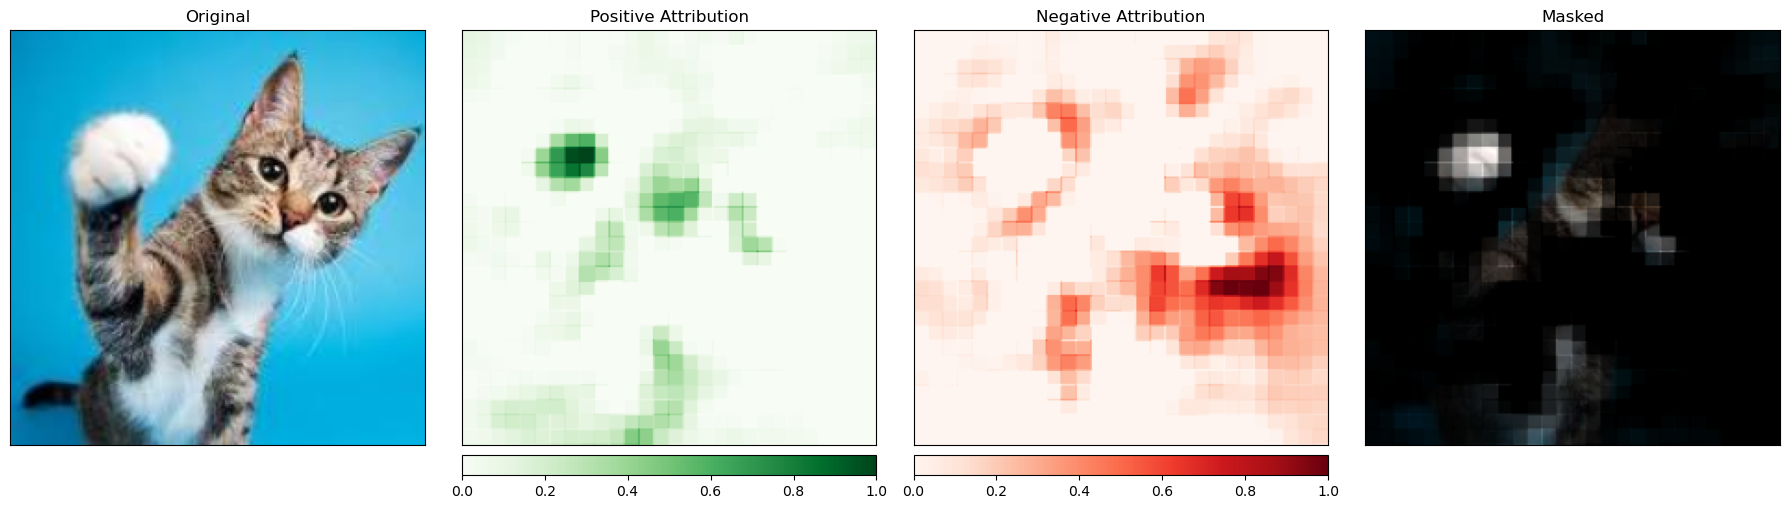

In [17]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input_img,
                                       target=pred_label_idx,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )

* 이번에도 고양이가 포함된 이미지 영역에 더 큰 의미가 있음을 알 수 있음.

### Layer Attribution with Layer GradCAM
* **Layer Attribution** 을 사용하면 모델 내 숨겨진 레이어의 활동을 입력 기능에 귀속시킬 수 있음.
* 아래에서는 레이어 속성 알고리즘을 사용하여 모델 내 컨볼루션 레이어 중 하나의 활동을 검사함.
* GradCAM은 주어진 레이어에 대한 대상 출력의 기울기, 각 출력 채널(출력의 차원 2)에 대한 평균을 계산하고 각 채널의 평균 기울기에 레이어 활성화를 곱함.
* 결과는 모든 채널에서 합산됨.
* GradCAM은 ConvNet용으로 설계됨.
* 컨볼루션 레이어의 활동은 공간적으로 입력에 매핑되는 경우가 많기 때문에 GradCAM 속성은 종종 업샘플링되어 입력을 마스크하는 데 사용됨.
* 레이어 속성은 모델 외에도 검사하려는 모델 내에서 숨겨진 레이어를 지정해야 한다는 점을 제외하면 입력 속성과 유사하게 설정됨.
* 위와 같이 attribute()를 호출할 때 관심 있는 대상 클래스를 지정함.

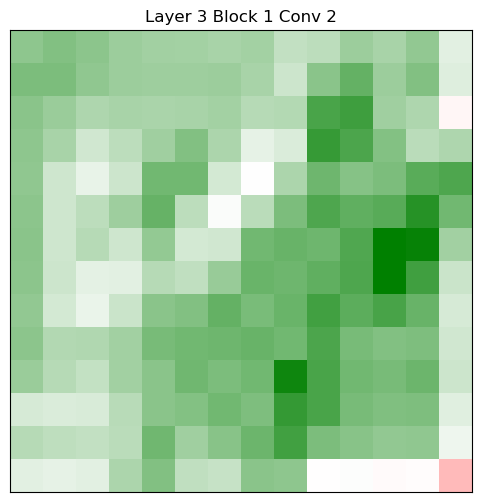

In [18]:
layer_gradcam = LayerGradCam(model, model.layer3[1].conv2)
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)

_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign="all",
                             title="Layer 3 Block 1 Conv 2")

* LayerAttribution 기본 클래스의 편리한 메서드 interpolate()를 사용하여 입력 이미지와 비교하기 위해 이 속성 데이터를 업샘플링함.

torch.Size([1, 1, 14, 14])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


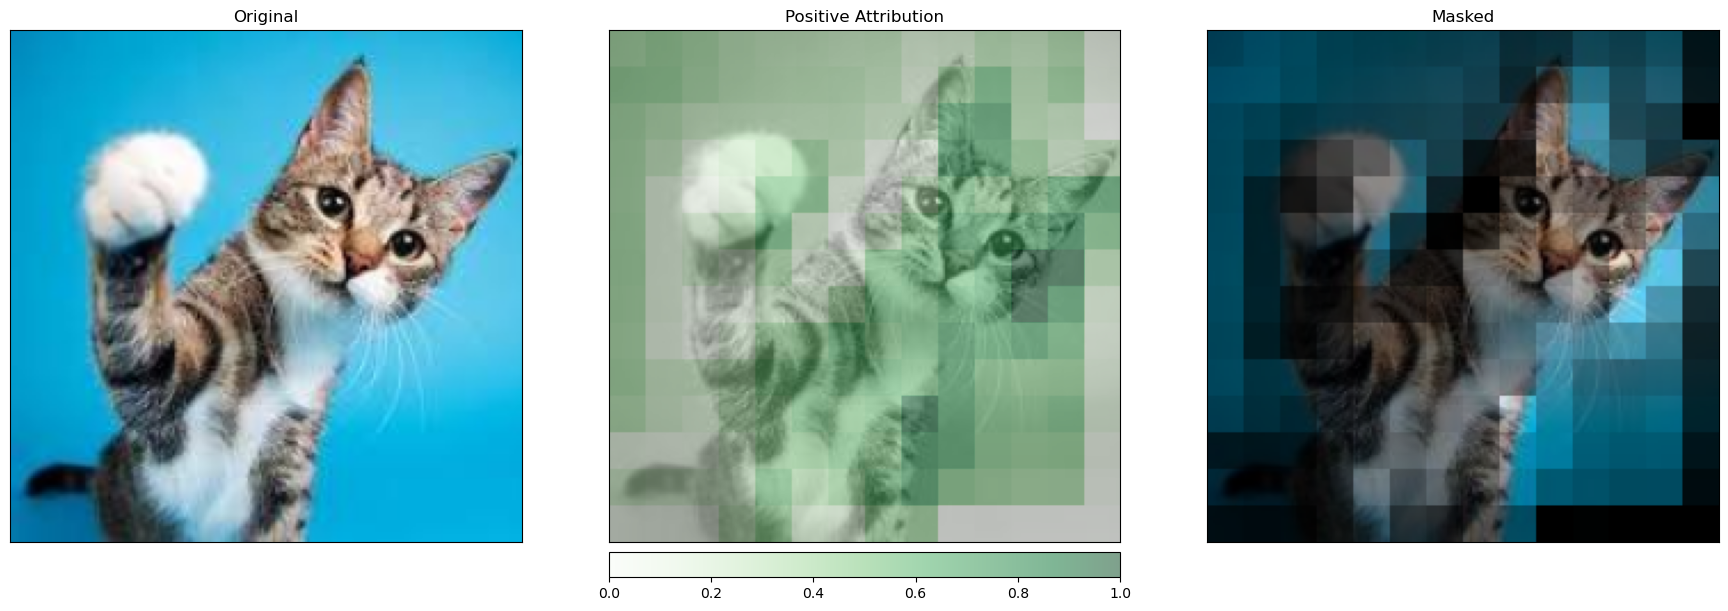

In [19]:
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(input_img.shape)

_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))

* 이와 같은 시각화를 통해 숨겨진 레이어가 입력에 어떻게 반응하는지에 대한 새로운 통찰력을 얻을 수 있음.

### Visualization with Captum Insights
* Captum Insights는 모델 이해를 돕기 위해 Captum 위에 구축된 해석 가능성 시각화 위젯임.
* Captum Insights는 이미지, 텍스트 및 기타 기능 전반에 걸쳐 작동하여 사용자가 기능 속성을 이해하는 데 도움을 줌.
* 여러 입력/출력 쌍에 대한 속성을 시각화할 수 있으며 이미지, 텍스트 및 임의 데이터에 대한 시각화 도구를 제공함.
* Notebook의 이 섹션에서는 Captum Insights를 사용하여 여러 이미지 분류 추론을 시각화함.
* 먼저 이미지를 모아 모델이 이에 대해 어떻게 생각하는지 살펴보겠음.
* 다양성을 위해 고양이, 찻주전자, 삼엽충 화석을 선택함.

In [20]:
imgs = ['img/cat.jpg', 'img/teapot.jpg', 'img/trilobite.jpg']

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

Predicted: tabby / 281  ( 0.5821260213851929 )
Predicted: teapot / 849  ( 0.9690598845481873 )
Predicted: trilobite / 69  ( 0.7607277631759644 )


* 그리고 우리 모델이 그것들을 모두 정확하게 식별하는 것 같음.
* 물론 우리는 더 깊이 파고들고 싶음.
* 이를 위해 아래에서 가져온 AttributionVisualizer 개체로 구성한 Captum Insights 위젯을 사용하겠음.
* AttributionVisualizer는 일괄 데이터를 예상하므로 Captum의 Batch 도우미 클래스를 가져옴.
* 그리고 구체적으로 이미지를 살펴볼 것이므로 ImageFeature도 가져옴.
* 다음 인수를 사용하여 AttributionVisualizer를 구성함.
  + 검사할 모델의 배열(이 경우에는 하나만)
  + Captum Insights가 모델에서 상위 k 예측을 추출할 수 있는 채점 기능
  + 우리 모델이 훈련된 클래스의 순서가 있고 사람이 읽을 수 있는 목록임.
  + 찾아야 할 기능 목록 - ImageFeature (이 모델은)
  + 훈련에 사용하는 것과 마찬가지로 입력 및 레이블 배치를 반환하는 반복 가능한 객체인 데이터 세트

In [21]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# Baseline is all-zeros input - this may differ depending on your data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    return i


input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=list(map(lambda k: idx_to_labels[k][1], idx_to_labels.keys())),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=[Batch(input_imgs, labels=[282,849,69])]
)

* 위의 속성과 달리 위의 셀을 실행하는 데 시간이 많이 걸리지 않았음.
* Captum Insights를 사용하면 시각적 위젯에서 다양한 속성 알고리즘을 구성한 후 속성을 계산하고 표시할 수 있기 때문임.
* 해당 과정은 몇 분 정도 소요됨.
* 아래 셀을 실행하면 Captum Insights 위젯이 렌더링됨.
* 그런 다음 기여 분석 방법과 해당 인수를 선택하고, 예측 클래스 또는 예측 정확성을 기반으로 모델 응답을 필터링하고, 관련 확률로 모델의 예측을 확인하고, 원본 이미지와 비교하여 기여 분석의 히트맵을 볼 수 있음.

In [22]:
visualizer.render()

CaptumInsights(insights_config={'classes': ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhe…

Output()